# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [45]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [46]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 

# using the SQL Table to read data.
import mysql.connector
con=mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="Mother9922*",
    database='data'
    )

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [47]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

KeyboardInterrupt: 

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

### Preparing data for models

In [ ]:
final.columns

In [ ]:
final['preprocessed_reviews']=preprocessed_reviews
final.columns

In [ ]:
final_sorted_data=final.sort_values(by='Time')
print(final_sorted_data.shape)

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation
print(final_sorted_data.shape)
print(type(final_sorted_data))

In [ ]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

### Splitting into train,cv and test sets

In [ ]:
print(X.shape)
print(Y.shape)
print(type(Y))

In [ ]:
#splitting the data before vectorizing
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
def bow(data):
    text_bow = vectorizer.transform(data)
    return text_bow
vectorizer.fit(x_train)
train_bow=bow(x_train)
test_bow=bow(x_test)
cv_bow=bow(x_cv)
bow_feature_name=vectorizer.get_feature_names()

In [ ]:
bow_feature_name

In [ ]:
print(train_bow.shape)
print(cv_bow.shape)
print(test_bow.shape)

### Training and Testing

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,auc
from tqdm import tqdm
train_auc=[]
cv_auc=[]
n_estimators = [10, 50, 100, 150, 200, 300, 500, 1000]
for n in tqdm(n_estimators):
    clf=RandomForestClassifier(n_estimators=n)
    clf.fit(train_bow,y_train)
    train_prob=[]
    for i in range(0,train_bow.shape[0],1000):
        train_prob.extend(clf.predict_proba(train_bow[i:i+1000])[:,1])
    cv_prob=[]
    for i in range(0,cv_bow.shape[0],1000):
        cv_prob.extend(clf.predict_proba(cv_bow[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,train_prob))
    cv_auc.append(roc_auc_score(y_cv,cv_prob))

In [ ]:
import math
plt.plot(n_estimators,train_auc,label='train_auc')
plt.plot(n_estimators,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(n_estimators,train_auc)
plt.scatter(n_estimators,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of depth')
plt.show()

In [ ]:
parameter = {'n_estimators' : [50,100,500,1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_bow,y_train)

In [ ]:
n_estimators=[50,100,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
print(len(train_auc))
sns.heatmap(train_auc,annot=True,xticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10],yticklabels=[50,100,500,1000])

In [ ]:
n_estimators=[50,100,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_auc,annot=True,xticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10],yticklabels=[50,100,500,1000])

In [ ]:
est = [10,50,100,150,200,300,500,1000]
max_depth = []
for i in range(2,11):
    for e in range(8):
        max_depth.append(i)
estimator=[]
for i in range(9):
    for e in est:
        estimator.append(e)

In [ ]:
%matplotlib inline
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

In [ ]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></scr
ipt>'''))
  init_notebook_mode(connected=False)


In [48]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
plt.show()

In [49]:
Gridcv.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [50]:
model=RandomForestClassifier(max_depth = 10, n_estimators = 1000)
model.fit(train_bow,y_train)
y_train_pred=[]
for i in tqdm(range(0,train_bow.shape[0],1000)):
    y_train_pred.extend(model.predict_proba(train_bow[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,test_bow.shape[0],1000)):
    y_test_pred.extend(model.predict_proba(test_bow[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Text(0, 0.5, 'True positive rate')

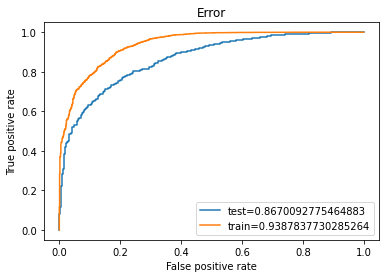

In [51]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [52]:
print(thresholds_test.shape)

(590,)


In [53]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high        
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold",t)    
    predictions = []    
    for i in proba:      
        if i>=t:            
            predictions.append(1)       
        else:           
            predictions.append(0)
    return predictions


Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.731413177349802 for threshold 0.8385044205907279
[[ 867  121]
 [ 980 4056]]
the maximum value of tpr*(1-fpr) 0.731413177349802 for threshold 0.8385044205907279


<AxesSubplot:>

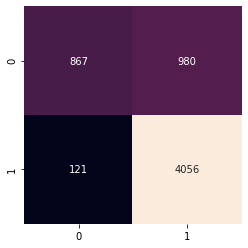

In [54]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 

Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6115184716233095 for threshold 0.8286050747829223
[[ 347  144]
 [ 438 1941]]
the maximum value of tpr*(1-fpr) 0.6115184716233095 for threshold 0.8286050747829223


<AxesSubplot:>

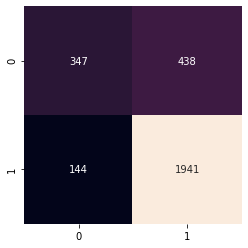

In [55]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [56]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
print(final_sorted_data.shape)
print(type(final_sorted_data))

(9564, 11)
<class 'pandas.core.frame.DataFrame'>


In [57]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

### Splitting into train,cv and test sets

In [58]:
print(X.shape)
print(Y.shape)
print(type(Y))

(9564,)
(9564,)
<class 'pandas.core.series.Series'>


In [59]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(6024,)
(6024,)
(2870,)
(2870,)
(670,)
(670,)


In [60]:
vectorizer = tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
def tfidf(data):
    text_tfidf = vectorizer.transform(data)
    return text_tfidf

vectorizer.fit(x_train)
train_tfidf=tfidf(x_train)
test_tfidf=tfidf(x_test)
cv_tfidf=tfidf(x_cv)
tfidf_feature_name=vectorizer.get_feature_names()

In [61]:
tfidf_feature_name

['ability',
 'able',
 'able find',
 'able use',
 'absolute',
 'absolute best',
 'absolute favorite',
 'absolutely',
 'absolutely delicious',
 'absolutely love',
 'absolutely loves',
 'acacia',
 'according',
 'account',
 'acerola',
 'acid',
 'acidic',
 'acidity',
 'acquired',
 'across',
 'active',
 'actual',
 'actually',
 'add',
 'add little',
 'add water',
 'added',
 'added bonus',
 'added sugar',
 'added sugars',
 'addict',
 'addicted',
 'addicting',
 'addictive',
 'adding',
 'addition',
 'additional',
 'additives',
 'adds',
 'adequate',
 'admit',
 'adopted',
 'adore',
 'adult',
 'adults',
 'advantage',
 'advertised',
 'advice',
 'afford',
 'affordable',
 'afraid',
 'afternoon',
 'aftertaste',
 'aftertaste not',
 'afterwards',
 'agave',
 'age',
 'ages',
 'ago',
 'agree',
 'ahead',
 'aid',
 'air',
 'air tight',
 'alcohol',
 'allergic',
 'allergies',
 'allergy',
 'allow',
 'allowed',
 'allowing',
 'allows',
 'almond',
 'almond milk',
 'almonds',
 'almost',
 'almost every',
 'almost like

In [62]:
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(6024, 3793)
(670, 3793)
(2870, 3793)


### Training and Testing

In [63]:
parameter = {'n_estimators' : [ 50, 100, 200, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_tfidf,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             return_train_score=True, scoring='roc_auc')

In [64]:
Gridcv.best_params_

{'max_depth': 10, 'n_estimators': 1000}

<AxesSubplot:>

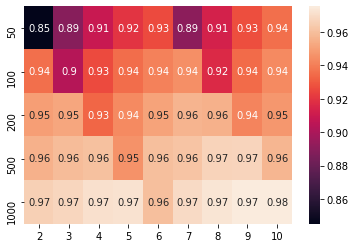

In [65]:
n_estimators=[50,100,200,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

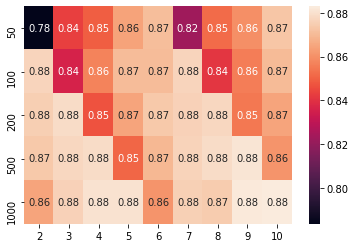

In [66]:
n_estimators=[50,100,200,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
test_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(test_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

In [67]:
train_auc=[]
cv_auc=[]
n_estimators = [10, 50, 100, 150, 200, 300, 500, 1000]
parameter={'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
for K in n_estimators:
    clf=RandomForestClassifier(n_estimators=K)
    Gridcv=GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
    Gridcv.fit(train_tfidf,y_train)
    train_auc.extend(Gridcv.cv_results_['mean_train_score'])
    cv_auc.extend(Gridcv.cv_results_['mean_test_score'])

In [70]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [71]:
train_auc=[]
cv_auc=[]
n_estimators = [10, 50, 100, 150, 200, 300, 500, 1000]
for n in tqdm(n_estimators):
    clf=RandomForestClassifier(n_estimators=n,min_samples_split=10)
    clf.fit(train_tfidf,y_train)
    train_prob=[]
    for i in range(0,train_tfidf.shape[0],1000):
        train_prob.extend(clf.predict_proba(train_tfidf[i:i+1000])[:,1])
    cv_prob=[]
    for i in range(0,cv_tfidf.shape[0],1000):
        cv_prob.extend(clf.predict_proba(cv_tfidf[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,train_prob))
    cv_auc.append(roc_auc_score(y_cv,cv_prob))


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:40<00:00, 12.55s/it]


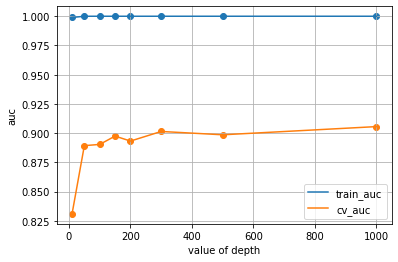

In [72]:
import math
log_N=[math.log(i) for i in n_estimators]
plt.plot(n_estimators,train_auc,label='train_auc')
plt.plot(n_estimators,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(n_estimators,train_auc)
plt.scatter(n_estimators,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of depth')
plt.show()


In [73]:
from sklearn.ensemble import RandomForestClassifier
best_params={'n_estimators':1000,'max_depth':10}


In [74]:
model=RandomForestClassifier(n_estimators=1000,max_depth=10)
model.fit(train_tfidf,y_train)
y_train_pred=[]
for i in tqdm(range(0,train_tfidf.shape[0],1000)):
    y_train_pred.extend(model.predict_proba(train_tfidf[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,test_tfidf.shape[0],1000)):
    y_test_pred.extend(model.predict_proba(test_tfidf[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Text(0, 0.5, 'True positive rate')

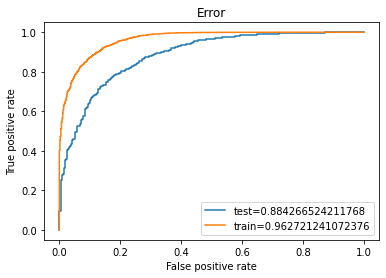

In [75]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.788768237113833 for threshold 0.8369334002176487
[[ 898   90]
 [ 741 4295]]
the maximum value of tpr*(1-fpr) 0.788768237113833 for threshold 0.8369334002176487


<AxesSubplot:>

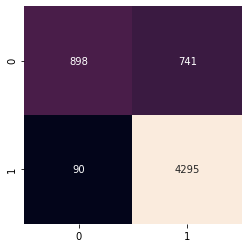

In [76]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6421873675721628 for threshold 0.8313193948065938
[[ 378  113]
 [ 438 1941]]
the maximum value of tpr*(1-fpr) 0.6421873675721628 for threshold 0.8313193948065938


<AxesSubplot:>

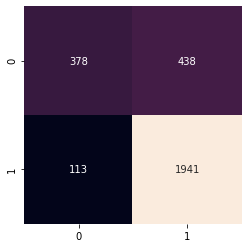

In [77]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [78]:
# Please write all the code with proper documentation
final_sorted_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'preprocessed_reviews'],
      dtype='object')

In [79]:
# load the whole embedding into memory
model = dict()
f = open('F:\APPLIED_AI_COURSE\CASE STUDY MACHINE LEARNING\CASE STUDY-AMAZON FINE FOOD REVIEWS\glove.6B.200d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	model[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(model))

Loaded 400000 word vectors.


In [80]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v(data):
    glove_words =  set(model.keys())
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in data: # for each review/sentence
        vector = np.zeros(200) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors


In [81]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

In [82]:
from sklearn.model_selection import train_test_split
x_train,test_avgw2v,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
train_avgw2v,cv_avgw2v,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(len(train_avgw2v))
print(len(y_train))
print(len(test_avgw2v))
print(len(y_test))
print(len(cv_avgw2v))
print(len(y_cv))

6024
6024
2870
2870
670
670


In [83]:
train_avgw2v=avg_w2v(train_avgw2v)
cv_avgw2v=avg_w2v(cv_avgw2v)
test_avgw2v=avg_w2v(test_avgw2v)

In [84]:
print(len(train_avgw2v))
print(len(y_train))
print(len(test_avgw2v))
print(len(y_test))
print(len(cv_avgw2v))
print(len(y_cv))

6024
6024
2870
2870
670
670


In [85]:
train_avgw2v

[array([ 2.41580109e-01,  1.05389370e-01, -3.09027262e-01,  1.46383581e-01,
        -1.20912667e-02, -1.46010470e-01, -2.44549996e-01,  8.40083159e-02,
         1.93810895e-01,  1.57469065e-01, -1.24686473e-01,  1.20541735e-01,
        -4.06393666e-02, -2.66097548e-01, -2.71457369e-01, -1.59618441e-02,
        -6.71042124e-02,  6.62671689e-02,  4.15531558e-02,  1.88320738e-01,
         2.07171138e-04,  1.43945156e+00, -3.06785368e-01,  2.01256830e-02,
        -2.43153715e-02, -2.82025059e-01, -2.50617641e-01,  4.57625688e-01,
        -2.04751597e-02,  1.36466836e-01,  1.35107755e-01, -1.28147312e-01,
        -1.32267682e-01,  4.70576863e-02, -7.09808432e-02,  6.19655525e-02,
         1.05239479e-01, -5.09984132e-02,  1.70815569e-01,  4.28409769e-02,
         1.36546735e-01,  2.22531742e-01,  1.52573266e-01,  1.45734842e-01,
        -3.88810938e-02,  7.06045797e-02,  5.79848475e-01, -4.15204192e-02,
        -8.04363005e-03,  6.15655369e-01, -1.67288579e-01,  6.54849947e-02,
        -5.2

### Training and Testing

In [86]:
parameter = {'n_estimators' : [ 50, 100, 300, 500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_avgw2v,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 300, 500]},
             return_train_score=True, scoring='roc_auc')

In [87]:
Gridcv.best_params_

{'max_depth': 6, 'n_estimators': 500}

<AxesSubplot:>

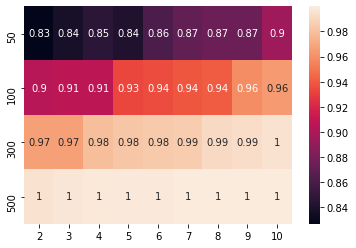

In [88]:
n_estimators=[50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

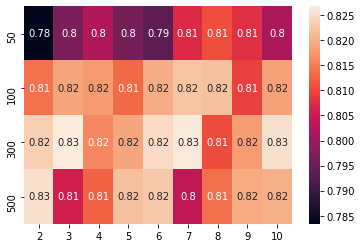

In [89]:
n_estimators=[50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
test_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(test_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,auc
from tqdm import tqdm
train_auc=[]
cv_auc=[]
n_estimators = [10, 50, 100, 150, 200, 300, 500]
for n in tqdm(n_estimators):
    clf=RandomForestClassifier(n_estimators=n)
    clf.fit(train_avgw2v,y_train)
    train_prob=[]
    for i in range(0,len(train_avgw2v),1000):
        train_prob.extend(clf.predict_proba(train_avgw2v[i:i+1000])[:,1])
    cv_prob=[]
    for i in range(0,len(cv_avgw2v),1000):
        cv_prob.extend(clf.predict_proba(cv_avgw2v[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,train_prob))
    cv_auc.append(roc_auc_score(y_cv,cv_prob))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:26<00:00, 12.37s/it]


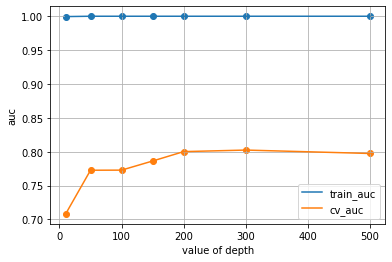

In [91]:
n_estimators = [10, 50, 100, 150, 200, 300, 500]
import math
log_N=[math.log(i) for i in n_estimators]
plt.plot(n_estimators,train_auc,label='train_auc')
plt.plot(n_estimators,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(n_estimators,train_auc)
plt.scatter(n_estimators,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of depth')
plt.show()

In [92]:
model=RandomForestClassifier(n_estimators=300,max_depth=8)
model.fit(train_avgw2v,y_train)
y_train_pred=[]
for i in tqdm(range(0,len(train_avgw2v),1000)):
    y_train_pred.extend(model.predict_proba(train_avgw2v[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,len(test_avgw2v),1000)):
    y_test_pred.extend(model.predict_proba(test_avgw2v[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.39it/s]


Text(0, 0.5, 'True positive rate')

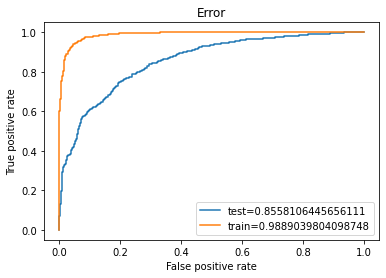

In [93]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.8954867062413778 for threshold 0.8064753491569034
[[ 946   42]
 [ 373 4663]]
the maximum value of tpr*(1-fpr) 0.8954867062413778 for threshold 0.8064753491569034


<AxesSubplot:>

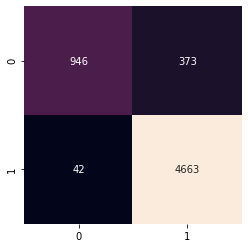

In [94]:
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6027708505088225 for threshold 0.8152206405015169
[[ 374  117]
 [ 540 1839]]
the maximum value of tpr*(1-fpr) 0.6027708505088225 for threshold 0.8152206405015169


<AxesSubplot:>

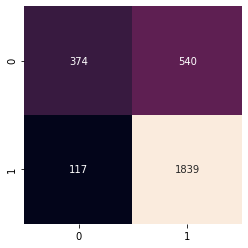

In [95]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [96]:
# Please write all the code with proper documentation

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [97]:
# Please write all the code with proper documentation
final_sorted_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'preprocessed_reviews'],
      dtype='object')

In [98]:
# load the whole embedding into memory
model = dict()
f = open('F:\APPLIED_AI_COURSE\CASE STUDY MACHINE LEARNING\CASE STUDY-AMAZON FINE FOOD REVIEWS\glove.6B.200d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	model[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(model))

Loaded 400000 word vectors.


In [99]:
# TF-IDF weighted Word2Vec
# average Word2Vec
# compute average word2vec for each review
def tfidf_weighted_w2v(data,tfidf_words):
    glove_words =  set(model.keys())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in data: # for each review/sentence
        vector = np.zeros(200) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors


In [100]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

In [101]:
print(len(X))
print(len(Y))
print(type(Y))

9564
9564
<class 'pandas.core.series.Series'>


In [102]:
from sklearn.model_selection import train_test_split
x_train,test_tfidfw2v,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
train_tfidfw2v,cv_tfidfw2v,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(len(train_tfidfw2v))
print(len(y_train))
print(len(test_tfidfw2v))
print(len(y_test))
print(len(cv_tfidfw2v))
print(len(y_cv))

6024
6024
2870
2870
670
670


In [103]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_tfidfw2v)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [104]:
train_tfidfw2v=tfidf_weighted_w2v(train_tfidfw2v,tfidf_words)
cv_tfidfw2v=tfidf_weighted_w2v(cv_tfidfw2v,tfidf_words)
test_tfidfw2v=tfidf_weighted_w2v(test_tfidfw2v,tfidf_words)

In [105]:
parameter = {'n_estimators' : [50, 100, 300, 500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_tfidfw2v,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 300, 500]},
             return_train_score=True, scoring='roc_auc')

In [106]:
Gridcv.best_params_

{'max_depth': 5, 'n_estimators': 500}

<AxesSubplot:>

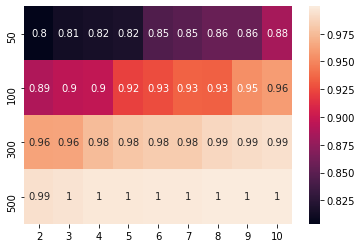

In [107]:
n_estimators=[50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

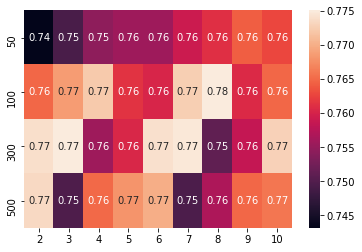

In [108]:
n_estimators=[50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

In [109]:
est = [10,50,100,150,200,300,500]
max_depth = []
for i in range(2,11):
    for e in range(8):
        max_depth.append(i)
estimator=[]
for i in range(9):
    for e in est:
        estimator.append(e)


In [110]:
train_auc=Gridcv.cv_results_['mean_train_score']
cv_auc=Gridcv.cv_results_['mean_test_score']

In [111]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


In [112]:
model=RandomForestClassifier(n_estimators=500,max_depth=6)
model.fit(train_tfidfw2v,y_train)
y_train_pred=[]
for i in tqdm(range(0,len(train_tfidfw2v),1000)):
    y_train_pred.extend(model.predict_proba(train_tfidfw2v[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,len(test_tfidfw2v),1000)):
    y_test_pred.extend(model.predict_proba(test_tfidfw2v[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.79it/s]


Text(0, 0.5, 'True positive rate')

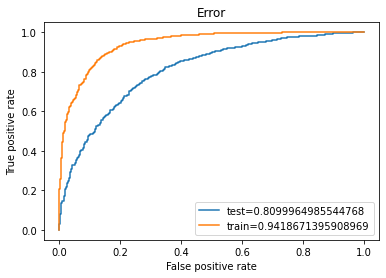

In [113]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.7556590523936161 for threshold 0.8378758397796594
[[ 902   86]
 [1183 3853]]
the maximum value of tpr*(1-fpr) 0.7556590523936161 for threshold 0.8378758397796594


<AxesSubplot:>

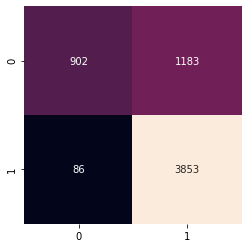

In [114]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.5482630176296498 for threshold 0.8444148311781707
[[ 391  100]
 [ 851 1528]]
the maximum value of tpr*(1-fpr) 0.5482630176296498 for threshold 0.8444148311781707


<AxesSubplot:>

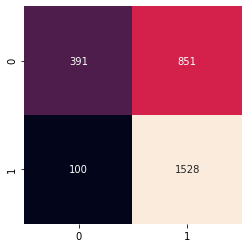

In [115]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [116]:
# Please write all the code with proper documentation
from sklearn.ensemble import GradientBoostingClassifier


In [117]:
parameter = {'n_estimators' : [10, 50,100,300,500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_bow,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             return_train_score=True, scoring='roc_auc')

In [118]:
Gridcv.best_params_

{'max_depth': 3, 'n_estimators': 500}

<AxesSubplot:>

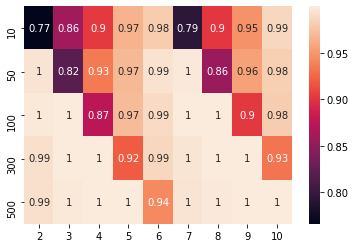

In [119]:
n_estimators=[10,50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

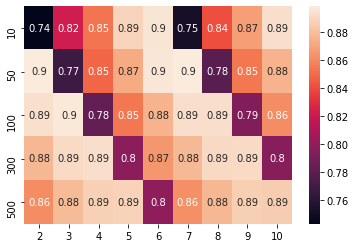

In [120]:
n_estimators=[10,50,100,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)


In [121]:
est = [10,50,100,500]
max_depth = []
for i in range(2,11):
    for e in range(4):
        max_depth.append(i)
estimator=[]
for i in range(9):
    for e in est:
        estimator.append(e)

In [122]:
train_auc=Gridcv.cv_results_['mean_train_score']
cv_auc=Gridcv.cv_results_['mean_test_score']

In [123]:
parameter = {'n_estimators' : [100], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv1 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv1.fit(train_bow,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100]},
             return_train_score=True, scoring='roc_auc')

In [124]:
Gridcv1.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [125]:
train_auc1=Gridcv1.cv_results_['mean_train_score']
cv_auc1=Gridcv1.cv_results_['mean_test_score']
print(train_auc1)
print(cv_auc1)

[0.90431602 0.94565609 0.97011769 0.9821635  0.98857854 0.99351223
 0.99599037 0.99789911 0.99834396]
[0.85398924 0.86658655 0.87468706 0.87490472 0.87598064 0.87459084
 0.87712629 0.87639862 0.87519942]


In [126]:
parameter = {'n_estimators' : [500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8,9,10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv2 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv2.fit(train_bow,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [500]},
             return_train_score=True, scoring='roc_auc')

In [127]:
Gridcv2.best_params_

{'max_depth': 3, 'n_estimators': 500}

In [128]:
train_auc2=Gridcv2.cv_results_['mean_train_score']
cv_auc2=Gridcv2.cv_results_['mean_test_score']
print(train_auc2)
print(cv_auc2)

[0.98077235 0.99496965 0.99852134 0.99940054 0.99967736 0.99984275
 0.99990728 0.99991602 0.99992002]
[0.89656146 0.89867087 0.89674437 0.89749847 0.89439979 0.89237401
 0.89032925 0.88768243 0.88350935]


In [129]:
train_score=[]
train_score.extend(train_auc)
train_score.extend(train_auc1)
train_score.extend(train_auc2)
cv_score=[]
cv_score.extend(cv_auc)
cv_score.extend(cv_auc1)
cv_score.extend(cv_auc2)


In [130]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_score, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_score, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


In [131]:
parameter = {'n_estimators' :[50,100], 'max_depth' :[8]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_bow,y_train)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [8], 'n_estimators': [50, 100]},
             return_train_score=True, scoring='roc_auc')

In [132]:
Gridcv.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [133]:
parameter = {'n_estimators' :[500,100], 'max_depth' :[8,3]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_bow,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [8, 3], 'n_estimators': [500, 100]},
             return_train_score=True, scoring='roc_auc')

In [134]:
Gridcv.best_params_

{'max_depth': 3, 'n_estimators': 500}

In [135]:
model=GradientBoostingClassifier(n_estimators=500,max_depth=3)
model.fit(train_bow,y_train)
y_train_pred=[]
for i in tqdm(range(0,train_bow.shape[0],1000)):
    y_train_pred.extend(model.predict_proba(train_bow[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,test_bow.shape[0],1000)):
    y_test_pred.extend(model.predict_proba(test_bow[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 120.31it/s]


Text(0, 0.5, 'True positive rate')

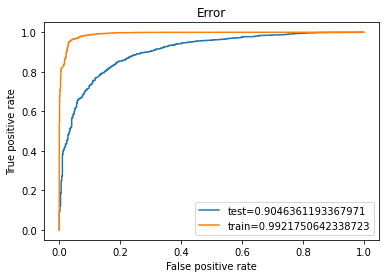

In [136]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.923503809012358 for threshold 0.8633799488532123
[[ 967   21]
 [ 664 4372]]
the maximum value of tpr*(1-fpr) 0.923503809012358 for threshold 0.8633799488532123


<AxesSubplot:>

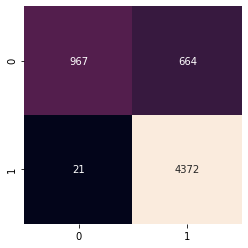

In [137]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6882395091469914 for threshold 0.8429178760105231
[[ 385  106]
 [ 335 2044]]
the maximum value of tpr*(1-fpr) 0.6882395091469914 for threshold 0.8429178760105231


<AxesSubplot:>

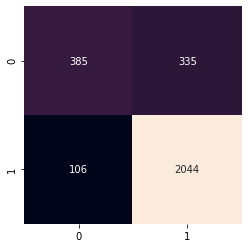

In [138]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [139]:
# Please write all the code with proper documentation
from sklearn.ensemble import GradientBoostingClassifier

In [140]:
parameter = {'n_estimators' : [50,300,500,1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv.fit(train_tfidf,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 300, 500, 1000]},
             return_train_score=True, scoring='roc_auc')

In [141]:
Gridcv.best_params_


{'max_depth': 2, 'n_estimators': 1000}

<AxesSubplot:>

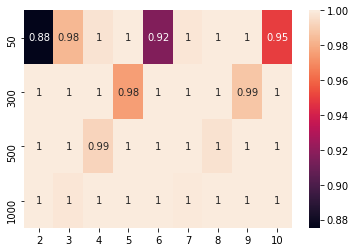

In [142]:
n_estimators=[50,300,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_auc=Gridcv.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

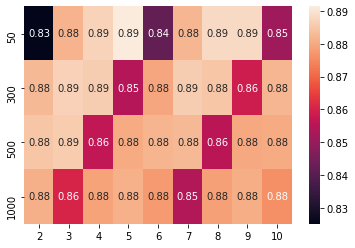

In [143]:
n_estimators=[50,300,500,1000]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_auc=Gridcv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_auc,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

In [144]:
model=GradientBoostingClassifier(n_estimators=500,max_depth=3)
model.fit(train_tfidf,y_train)
y_train_pred=[]
for i in tqdm(range(0,train_tfidf.shape[0],1000)):
    y_train_pred.extend(model.predict_proba(train_tfidf[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,test_tfidf.shape[0],1000)):
    y_test_pred.extend(model.predict_proba(test_tfidf[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 120.18it/s]


Text(0, 0.5, 'True positive rate')

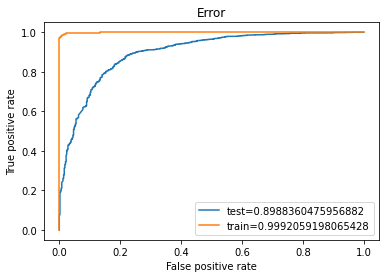

In [145]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.9771173863968897 for threshold 0.5866466966460588
[[ 875  113]
 [  11 5025]]
the maximum value of tpr*(1-fpr) 0.9771173863968897 for threshold 0.5866466966460588


<AxesSubplot:>

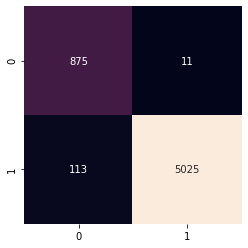

In [147]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6872490024304656 for threshold 0.9308684994783618
[[ 447   44]
 [ 883 1496]]
the maximum value of tpr*(1-fpr) 0.6872490024304656 for threshold 0.9308684994783618


<AxesSubplot:>

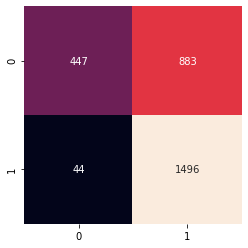

In [148]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1])

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [149]:
# Please write all the code with proper documentation
parameter = {'n_estimators' : [50,300], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv1 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv1.fit(train_avgw2v,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 300]},
             return_train_score=True, scoring='roc_auc')

In [151]:
parameter = {'n_estimators' : [500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassi;[fier()
Gridcv2 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv2.fit(train_avgw2v,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [500]},
             return_train_score=True, scoring='roc_auc')

In [152]:
train_auc1=Gridcv2.cv_results_['mean_train_score']
cv_auc1=Gridcv2.cv_results_['mean_test_score']
train_auc=Gridcv1.cv_results_['mean_train_score']
cv_auc=Gridcv1.cv_results_['mean_test_score']

In [153]:
train_score=[]
cv_score=[]
train_score.extend(train_auc1)
train_score.extend(train_auc)
cv_score.extend(cv_auc1)
cv_score.extend(cv_auc)

<AxesSubplot:>

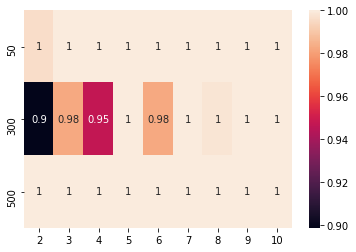

In [154]:
n_estimators=[50,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_area=np.array(train_score).reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_area,annot=True,xticklabels=max_depth,yticklabels=n_estimators)

<AxesSubplot:>

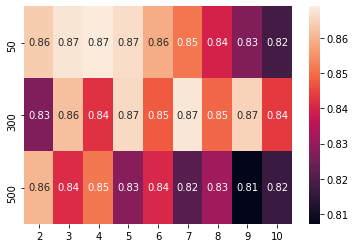

In [155]:
n_estimators=[50,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_area=np.array(cv_score).reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_area,annot=True,xticklabels=max_depth,yticklabels=n_estimators)


In [156]:
est = [50,100,500]
max_depth = []
for i in range(2,11):
    for e in range(3):
        max_depth.append(i)
estimator=[]
for i in range(9):
    for e in est:
        estimator.append(e)

In [157]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_score, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_score, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


In [158]:
from sklearn.ensemble import GradientBoostingClassifier


In [159]:
model=GradientBoostingClassifier(n_estimators=300,max_depth=3)
model.fit(train_avgw2v,y_train)
y_train_pred=[]
for i in tqdm(range(0,len(train_avgw2v),1000)):
    y_train_pred.extend(model.predict_proba(train_avgw2v[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,len(test_avgw2v),1000)):
    y_test_pred.extend(model.predict_proba(test_avgw2v[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 107.54it/s]


Text(0, 0.5, 'True positive rate')

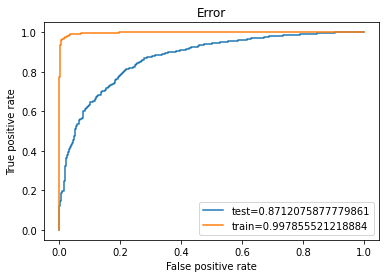

In [160]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


Train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.9562526328652328 for threshold 0.7363212431981438
[[ 968   20]
 [ 145 4891]]
the maximum value of tpr*(1-fpr) 0.9562526328652328 for threshold 0.7363212431981438


<AxesSubplot:>

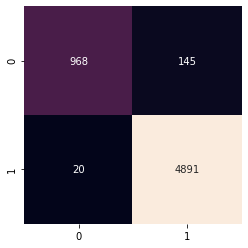

In [161]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


Test Confusion Matrix
the maximum value of tpr*(1-fpr) 0.6348060807010425 for threshold 0.8964269509489792
[[ 403   88]
 [ 623 1756]]
the maximum value of tpr*(1-fpr) 0.6348060807010425 for threshold 0.8964269509489792


<AxesSubplot:>

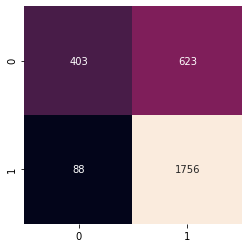

In [162]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [163]:
# Please write all the code with proper documentation
parameter = {'n_estimators' : [50,100], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv2 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv2.fit(train_tfidfw2v,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='roc_auc')

In [164]:
train_wtw2v=train_tfidfw2v
act_y=y_train

In [165]:
import scipy
train_auc=Gridcv2.cv_results_['mean_train_score']
cv_auc=Gridcv2.cv_results_['mean_test_score']
train_auc = scipy.sparse.csc_matrix(np.array(train_auc))
scipy.sparse.save_npz('train_auc.npz', train_auc)
cv_auc=scipy.sparse.csc_matrix(np.array(cv_auc))
scipy.sparse.save_npz('cv_auc.npz',cv_auc)


In [166]:
parameter = {'n_estimators' : [500], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingClassifier()
Gridcv1 = GridSearchCV(clf,parameter,cv=3,scoring='roc_auc',return_train_score=True)
Gridcv1.fit(train_wtw2v,act_y)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [500]},
             return_train_score=True, scoring='roc_auc')

In [167]:
train_auc1=Gridcv1.cv_results_['mean_train_score']
cv_auc1=Gridcv1.cv_results_['mean_test_score']


In [168]:
train_auc=Gridcv2.cv_results_['mean_train_score']
cv_auc=Gridcv2.cv_results_['mean_test_score']


In [169]:
train_score=[]
cv_score=[]
train_score.extend(train_auc)
train_score.extend(train_auc1)
cv_score.extend(cv_auc)
cv_score.extend(cv_auc1)


<AxesSubplot:>

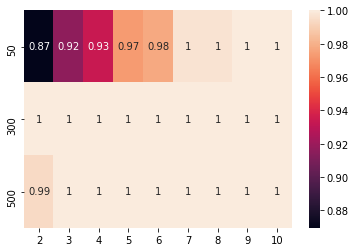

In [170]:
n_estimators=[50,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_area=np.array(train_score).reshape(len(n_estimators),len(max_depth))
sns.heatmap(train_area,annot=True,xticklabels=max_depth,yticklabels=n_estimators)


<AxesSubplot:>

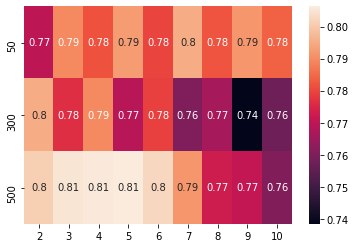

In [171]:
n_estimators=[50,300,500]
max_depth= [2, 3, 4, 5, 6, 7, 8, 9, 10]
cv_area=np.array(cv_score).reshape(len(n_estimators),len(max_depth))
sns.heatmap(cv_area,annot=True,xticklabels=max_depth,yticklabels=n_estimators)


In [172]:
est = [50,100,500]
max_depth = []
for i in range(2,11):
    for e in range(3):
        max_depth.append(i)
estimator=[]
for i in range(9):
    for e in est:
        estimator.append(e)


In [173]:
trace1 = go.Scatter3d(x=estimator,y=max_depth,z=train_score, name = 'train')
trace2 = go.Scatter3d(x=estimator,y=max_depth,z=cv_score, name = 'Cross validation')
data = [trace1, trace2]
enable_plotly_in_cell
layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


In [ ]:
model=GradientBoostingClassifier(n_estimators=50,max_depth=5)
model.fit(train_wtw2v,y_train)
y_train_pred=[]
for i in tqdm(range(0,train_wtw2v.shape[0],1000)):
    y_train_pred.extend(model.predict_proba(train_wtw2v[i:i+1000])[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
y_test_pred=[]
for i in tqdm(range(0,test_wtw2v.shape[0],1000)):
    y_test_pred.extend(model.predict_proba(test_wtw2v[i:i+1000])[:,1])
fpr_test,tpr_test,thresholds_test=roc_curve(y_test,y_test_pred)


In [ ]:
plt.title('Error')
plt.plot(fpr_test,tpr_test,label='test='+str(auc(fpr_test,tpr_test)))
plt.plot(fpr_train,tpr_train,label='train='+str(auc(fpr_train,tpr_train)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


In [ ]:
# Please write all the code with proper documentation
print('Train Confusion Matrix')
print(confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)))
tn,fp,fn,tp=confusion_matrix(y_train,predict(y_train_pred,thresholds_train,fpr_train,tpr_train)).r
avel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
xticklabels=[0,1], yticklabels=[0,1]) 


In [ ]:
print('Test Confusion Matrix')
print(confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)))
tn,fp,fn,tp=confusion_matrix(y_test,predict(y_test_pred,thresholds_test,fpr_test,tpr_test)).ravel()
mat=np.matrix([[tn,fn],[fp,tp]])
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,            
xticklabels=[0,1], yticklabels=[0,1]) 


# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table = PrettyTable()
table.field_names=['Set',"n_estimator","max_depth","auc"]
table.add_row(['BOW','1000','10','0.68'])
table.add_row(['Tfidf','1000','10','0.68'])
table.add_row(['Avgw2v','500','3','0.63'])
table.add_row(['Tfidfw2v','500','3','0.49'])
print("Random Forest")
print(table)
table1=PrettyTable()
table1.field_names=['Set',"n_estimator","max_depth","auc"]
table1.add_row(['BOW','500','3','0.70'])
table1.add_row(['Tfidf','500','3','0.70'])
table1.add_row(['Avgw2v','500','4','0.69'])
table1.add_row(['Tfidfw2v','50','5','0.69'])
print("Gradient Boosted Decision Tree")
print(table1)